In [2]:
import numpy as np
import tqdm 
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl 
import astropy.units as u
from astropy.constants import G, M_sun
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys

sys.path.append('../pipeline_scripts/')
from pipeline_main import pipeline, dist, calc_ang, sink_positions, dist
from pipeline_2D import to_osyris_ivs
from plotting_setup import *

In [3]:
data = pipeline(snap = 223, run = 's13_09_servoF', sink_id=13)

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 2753/2753 [00:04<00:00, 652.37it/s]


In [4]:
''' CODE UNITS:              (CGS)             (ASTRO)
                length:   1.234E+19            4.00 pc
                  time:   6.858E+14           21.73 Myr
                  mass:   5.994E+36         3013.80 M_Sun
              velocity:   1.800E+04
               density:   3.187E-21
              pressure:   1.033E-12
  energy per unit mass:   3.240E+08
 entropy per unit mass:   8.254E+07
 magnetic flux density:   3.602E-06
               gravity:   1.000E+02
           temperature:   3.925E+00'''

' CODE UNITS:              (CGS)             (ASTRO)\n                length:   1.234E+19            4.00 pc\n                  time:   6.858E+14           21.73 Myr\n                  mass:   5.994E+36         3013.80 M_Sun\n              velocity:   1.800E+04\n               density:   3.187E-21\n              pressure:   1.033E-12\n  energy per unit mass:   3.240E+08\n entropy per unit mass:   8.254E+07\n magnetic flux density:   3.602E-06\n               gravity:   1.000E+02\n           temperature:   3.925E+00'

In [5]:
u_m = 3.240E+08; u_grav = 1.000E+02

In [6]:
''''omega_dsk = sqrt(scaling%grav*self%mass/r_acc**3)*per_omega
    !---------------------------------------------------------------------------
    ! The omega_ff term allows for accretion onto a zero-mass embryo, to get
    ! things started.  The ratio of the omega_ff and omega_disk rate is
    ! f = sqrt(32.*d_max*r_acc**3/self%mass), which may be too dominant.
    !---------------------------------------------------------------------------
    omega_ff = sqrt(32.*scaling%grav*d_max/(3.*math%pi))*per_omega_ff'''

"'omega_dsk = sqrt(scaling%grav*self%mass/r_acc**3)*per_omega\n    !---------------------------------------------------------------------------\n    ! The omega_ff term allows for accretion onto a zero-mass embryo, to get\n    ! things started.  The ratio of the omega_ff and omega_disk rate is\n    ! f = sqrt(32.*d_max*r_acc**3/self%mass), which may be too dominant.\n    !---------------------------------------------------------------------------\n    omega_ff = sqrt(32.*scaling%grav*d_max/(3.*math%pi))*per_omega_ff"

In [7]:
sink_mass = data.sn.sinks[13][0].mass

In [8]:

r_acc = lambda acc_cells: acc_cells * ds
def get_d(acc_cells):
    acc_dens = []
    for p in data.sn.patches:
        acc_dens.extend(p.var('d')[p.dist_xyz < r_acc(acc_cells)].flatten()) 
    acc_dens = np.array(acc_dens) 
    return acc_dens, max(acc_dens), np.average(acc_dens)

In [9]:
ds = 0.5**data.lmax
dt_max = 2.3591439167150707e-07

def omega_dsk(acc_cells, per_omega): return np.sqrt(u_grav * sink_mass / r_acc(acc_cells)**3) * per_omega
@np.vectorize
def omega_ff(acc_cells, per_omega_ff): return np.sqrt(32 * u_grav * get_d(acc_cells)[1] / (3 * np.pi)) * per_omega_ff

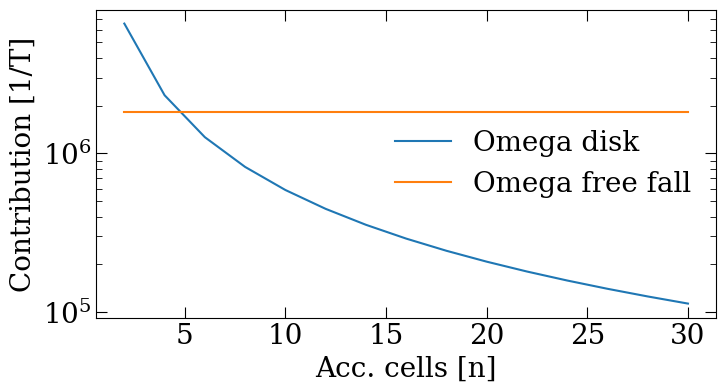

In [12]:
fig, axs = plt.subplots(figsize = (8,4))



axs.semilogy(ac, omega_dsk(ac, 1), label = 'Omega disk')
axs.semilogy(ac, omff, label = 'Omega free fall')
axs.set(ylabel = 'Contribution [1/T]', xlabel = 'Acc. cells [n]')
plt.legend(frameon= False)

In [13]:
omega_dsk(8, 1), omega_ff(8, 1)

(821312.1672543547, array(1814980.27035575))

In [14]:
'''omega = omega_dsk + omega_ff + omega_B
    fraction = omega*self%dtime
    if (verbose > 0 .and. omega_ff > omega_dsk) then
      write (stdmpi,'(a,i4,i8,4e8.3)') &
        'sink_t%accrete: free-fall collapse id, patch-id, fraction, sink-mass, omega_ff, omega_dsk=', &
        self%sink_id, patch%id, fraction, self%mass, omega_ff, omega_dsk
    end if
    fraction = fraction/(1.+fraction/max_acc_fraction)'''

"omega = omega_dsk + omega_ff + omega_B\n    fraction = omega*self%dtime\n    if (verbose > 0 .and. omega_ff > omega_dsk) then\n      write (stdmpi,'(a,i4,i8,4e8.3)') &\n        'sink_t%accrete: free-fall collapse id, patch-id, fraction, sink-mass, omega_ff, omega_dsk=', &\n        self%sink_id, patch%id, fraction, self%mass, omega_ff, omega_dsk\n    end if\n    fraction = fraction/(1.+fraction/max_acc_fraction)"

In [15]:
@np.vectorize
def fraction(acc_cells, per_omega, per_omega_ff, max_acc_fraction, dt = dt_max):
    fraction = (omega_dsk(acc_cells, per_omega) + omega_ff(acc_cells, per_omega_ff)) * dt_max
    return fraction / (1 + fraction / max_acc_fraction)

In [16]:
# sink_t%accrete: free-fall collapse id, patch-id, fraction, sink-mass, omega_ff, omega_dsk=  13    5594.528E-01.351E-04.221E+06.281E+04
dsk_run = .281E+04
ff_run = .221E+06
frac_run = .528E-01

In [17]:
for value in [dsk_run, ff_run, frac_run]:
    print(f'{value:3.1e}')


2.8e+03
2.2e+05
5.3e-02


In [18]:
f = (dsk_run + ff_run); f
frac_run / f, dt_max

(2.359143916715071e-07, 2.3591439167150707e-07)

In [19]:
f = 1e5
f / ( 1 + f / 0.8)

0.7999936000511996

In [20]:
for value in [omega_dsk(8, 1e-3), omega_ff(8, 1.), fraction(8, 0.001, 1, 0.8)]:
    print(f'{value:3.1e}')


8.2e+02
1.8e+06
2.8e-01


In [21]:
cells = np.arange(4, 20, 4)

In [22]:
frac_study = {key: [] for key in cells}

In [23]:
'''max_acc = np.logspace(-2, 0, 8)
per_omega = np.logspace(-3,0, 12)
xmax_acc, yper_omega = np.meshgrid(max_acc, per_omega, indexing='xy')
for key in tqdm.tqdm(frac_study.keys()):
    frac_study[key] = fraction(key, yper_omega, 1.0, xmax_acc)'''



"max_acc = np.logspace(-2, 0, 8)\nper_omega = np.logspace(-3,0, 12)\nxmax_acc, yper_omega = np.meshgrid(max_acc, per_omega, indexing='xy')\nfor key in tqdm.tqdm(frac_study.keys()):\n    frac_study[key] = fraction(key, yper_omega, 1.0, xmax_acc)"

In [24]:
'''[frac_study[key].max() for key in cells], [frac_study[key].min() for key in cells]'''

'[frac_study[key].max() for key in cells], [frac_study[key].min() for key in cells]'

In [26]:
'''fig, axs = plt.subplots(2,2, figsize = (10, 10), sharex=True, sharey = True)


for c, ax in zip(cells, axs.flatten()):
    cb = ax.pcolormesh(max_acc, per_omega, np.log10(frac_study[c]), vmin = -4, vmax = -1)
    ax.set_xscale('log'), ax.set_yscale('log')
    if c == 4 or c == 12: ax.set(ylabel = 'per_omega')
    if c == 12 or c == 16: ax.set(xlabel = 'max_accretion_fraction')
    ax.set(ylim= (per_omega[0], per_omega[-1]), xlim = (max_acc[0], max_acc[-1]))
    ax.text(0.99, 0.95, f'Acc_cells: {c}', transform=ax.transAxes, ha='right', va='top', fontsize = 12, color = 'black')

cbaxes = fig.add_axes([0.90, 0.125, 0.015, 0.69])
cbar = fig.colorbar(cb, cax = cbaxes)
fig.subplots_adjust(wspace=0, hspace=0)'''


"fig, axs = plt.subplots(2,2, figsize = (10, 10), sharex=True, sharey = True)\n\n\nfor c, ax in zip(cells, axs.flatten()):\n    cb = ax.pcolormesh(max_acc, per_omega, np.log10(frac_study[c]), vmin = -4, vmax = -1)\n    ax.set_xscale('log'), ax.set_yscale('log')\n    if c == 4 or c == 12: ax.set(ylabel = 'per_omega')\n    if c == 12 or c == 16: ax.set(xlabel = 'max_accretion_fraction')\n    ax.set(ylim= (per_omega[0], per_omega[-1]), xlim = (max_acc[0], max_acc[-1]))\n    ax.text(0.99, 0.95, f'Acc_cells: {c}', transform=ax.transAxes, ha='right', va='top', fontsize = 12, color = 'black')\n\ncbaxes = fig.add_axes([0.90, 0.125, 0.015, 0.69])\ncbar = fig.colorbar(cb, cax = cbaxes)\nfig.subplots_adjust(wspace=0, hspace=0)"

In [27]:
''''d_create = math%pi/scaling%grav/(ds*threshold_cells/sinks%csound)**2'''

"'d_create = math%pi/scaling%grav/(ds*threshold_cells/sinks%csound)**2"

In [28]:
def d_create(threshold_cells): return np.pi / u_grav / (ds * threshold_cells)**2

In [29]:
d_create_run = 8.63E+09

In [30]:
for value in [d_create(2), d_create_run]:
    print(f'{value:3.3e}')

8.636e+09
8.630e+09


In [31]:
'''if (nm > 0) then
      d_aver = sum(delta)/nm
      delta = 0.0
      where (radius2 < r_acc2)
        !-----------------------------------------------------------------------
        ! For densities below d_create, remove a fraction times a profile
        !-----------------------------------------------------------------------
        delta = fraction*(1-radius2/r_acc2)**2
        !-----------------------------------------------------------------------
        ! Reduce accretion if velocity is outflowing
        !-----------------------------------------------------------------------
        delta = min(1.,max(0.,1. - sign(vangle**2,vangle)))*delta
        !-----------------------------------------------------------------------
        ! Cut the fractional accretion gradually with density below d_aver
        !-----------------------------------------------------------------------
        delta = delta*(1.0-exp(-d/d_aver))
        !-----------------------------------------------------------------------
        ! Allow the new density to be at most d_create*max_create_fraction
        !-----------------------------------------------------------------------
        delta = max(delta,1.0-d_create*max_create_fraction/d)'''

'if (nm > 0) then\n      d_aver = sum(delta)/nm\n      delta = 0.0\n      where (radius2 < r_acc2)\n        !-----------------------------------------------------------------------\n        ! For densities below d_create, remove a fraction times a profile\n        !-----------------------------------------------------------------------\n        delta = fraction*(1-radius2/r_acc2)**2\n        !-----------------------------------------------------------------------\n        ! Reduce accretion if velocity is outflowing\n        !-----------------------------------------------------------------------\n        delta = min(1.,max(0.,1. - sign(vangle**2,vangle)))*delta\n        !-----------------------------------------------------------------------\n        ! Cut the fractional accretion gradually with density below d_aver\n        !-----------------------------------------------------------------------\n        delta = delta*(1.0-exp(-d/d_aver))\n        !-----------------------------------

In [32]:
def radius2(acc_cells):
    r2 = []
    for p in data.sn.patches:
        r2.extend(p.dist_xyz[p.dist_xyz < r_acc(acc_cells)].flatten()) 
    return np.array(r2)

In [33]:
frac = fraction(8, 0.001, 1, 0.8)

In [34]:
d = get_d(8)[0]
r2 = radius2(8)

In [35]:
d.max() > d_create(2)

True

In [ ]:
delta = frac * (1 - (r2**2 / r_acc(8)**2))**2

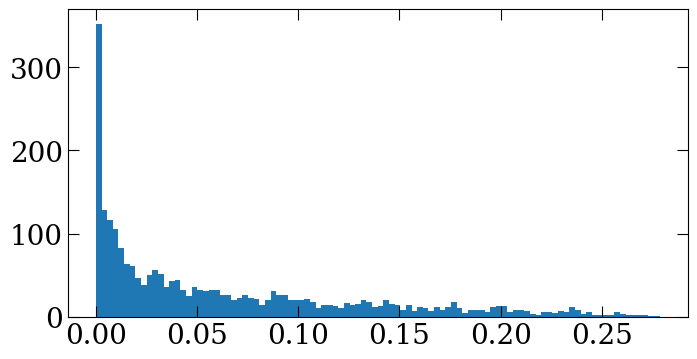

In [ ]:
fig, axs =plt.subplots(figsize=(8,4))

axs.hist(delta, bins = 100);

In [36]:
d, _, d_aver = get_d(8)

In [ ]:
delta_new = delta*(1.0-np.exp(-d/d_aver))

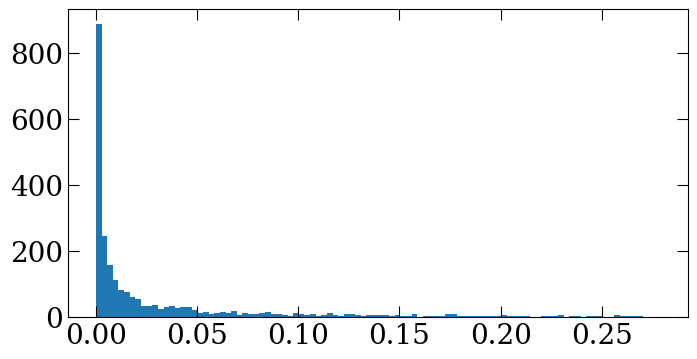

In [ ]:
fig, axs =plt.subplots(figsize=(8,4))

axs.hist(delta_new, bins = 100);

In [ ]:
'''1.0-d_create*max_create_fraction/d'''

'1.0-d_create*max_create_fraction/d'

In [38]:
d.min()

1510545.8

In [43]:
bins = np.logspace(start=np.log10((d_create(2)/d).min()), stop=np.log10((d_create(2)/d).max()), num=100)

In [44]:
bins

array([8.90071212e-01, 9.72493451e-01, 1.06254814e+00, 1.16094206e+00,
       1.26844744e+00, 1.38590802e+00, 1.51424567e+00, 1.65446761e+00,
       1.80767437e+00, 1.97506836e+00, 2.15796334e+00, 2.35779473e+00,
       2.57613088e+00, 2.81468536e+00, 3.07533042e+00, 3.36011170e+00,
       3.67126426e+00, 4.01123011e+00, 4.38267743e+00, 4.78852146e+00,
       5.23194740e+00, 5.71643540e+00, 6.24578788e+00, 6.82415938e+00,
       7.45608915e+00, 8.14653678e+00, 8.90092114e+00, 9.72516289e+00,
       1.06257309e+01, 1.16096933e+01, 1.26847723e+01, 1.38594057e+01,
       1.51428122e+01, 1.65450646e+01, 1.80771682e+01, 1.97511474e+01,
       2.15801401e+01, 2.35785010e+01, 2.57619137e+01, 2.81475146e+01,
       3.07540264e+01, 3.36019061e+01, 3.67135047e+01, 4.01132431e+01,
       4.38278035e+01, 4.78863391e+01, 5.23207026e+01, 5.71656964e+01,
       6.24593455e+01, 6.82431963e+01, 7.45626424e+01, 8.14672809e+01,
       8.90113016e+01, 9.72539126e+01, 1.06259805e+02, 1.16099659e+02,
      

In [52]:
d_create(2)/d[d_create(2)/d < 1]

array([0.8900712], dtype=float32)

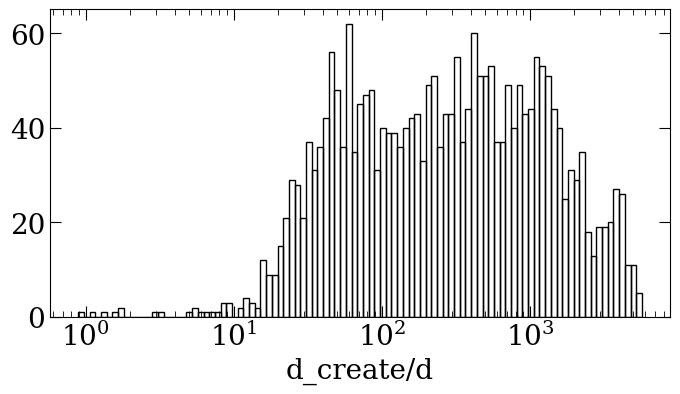

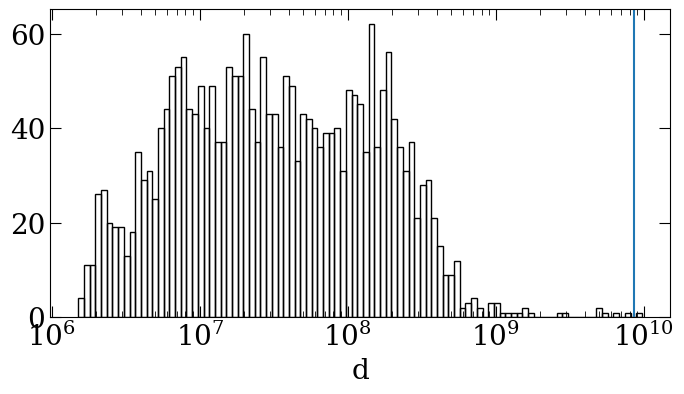

In [47]:
fig,axs = plt.subplots(figsize = (8,4));
axs.hist(d_create(2) / d, fill = False, bins = bins);
axs.set(xlabel = 'd_create/d')
axs.set_xscale('log')

fig,axs = plt.subplots(figsize = (8,4));
axs.hist(d, fill = False, bins = np.logspace(start=np.log10((d).min()), stop=np.log10((d).max()), num=100));
axs.set(xlabel = 'd')
axs.axvline(d_create_run)
axs.set_xscale('log')

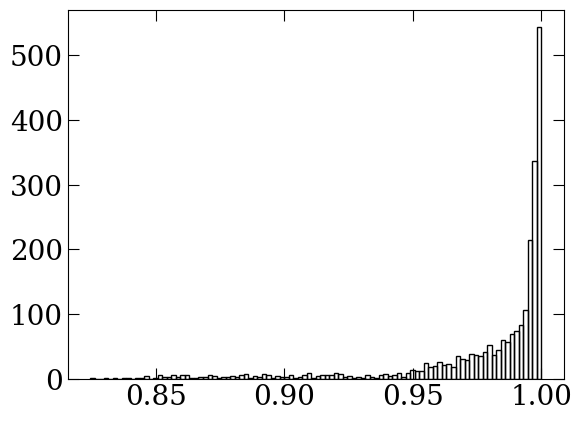

In [ ]:
plt.hist(1 - d_create(2) *1e-5 / d, bins = 100, fill = False);
